# Notebook de modelagem e avaliação 

## Importação das bibliotecas

In [190]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
import xgboost as xgb


In [191]:
# Configurar paleta de cores e estilo

# Matplotlib
mpl.rcParams["figure.figsize"] = (20, 7)
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["font.size"] = 12
mpl.rcParams["figure.titlesize"] = 25
mpl.rcParams["figure.dpi"] = 100

# Seaborn
sns.set_style('whitegrid', {"grid.color": ".8", "grid.linestyle": "--"})
sns.set_palette(palette='mako')

In [192]:
input_path = '../data/processed/arquivo-modelo.csv'

df = pd.read_csv(input_path)
df.tail()

,target,delta,return,return_1d,return_2d,return_3d,return_5d,momentum_aceel,momentum_consistency,vol_3d,...,target_lag2,target_lag3,target_lag4,target_lag5,target_lag6,target_lag7,close_lag1,close_lag3,close_lag5,close_lag7
4282,1.0,692.0,0.005072,0.005072,0.010531,0.007538,0.000920,-0.005459,1,0.004745,...,1.0,0.0,0.0,0.0,0.0,1.0,137128.0,135699.0,136236.0,137546.0
4283,0.0,672.0,0.004901,0.004901,0.009997,0.015483,0.011480,-0.005097,1,0.000271,...,1.0,1.0,0.0,0.0,0.0,0.0,137800.0,136436.0,136102.0,137002.0
4284,1.0,-587.0,-0.004260,-0.004260,0.000620,0.005695,0.008163,-0.004880,0,0.005339,...,1.0,1.0,1.0,0.0,0.0,0.0,137213.0,137128.0,135699.0,136236.0
4285,0.0,2043.0,0.014889,0.014889,0.010566,0.015518,0.026212,0.004323,1,0.009578,...,0.0,1.0,1.0,1.0,0.0,0.0,139256.0,137800.0,136436.0,136102.0
4286,0.0,-416.0,-0.002987,-0.002987,0.011857,0.007547,0.017620,-0.014845,0,0.010707,...,1.0,0.0,1.0,1.0,1.0,0.0,138840.0,137213.0,137128.0,135699.0


In [193]:
# Porcentagem da distribuição da tendência
df['target'].value_counts(normalize=True)

target
1.0    0.513879
0.0    0.486121
Name: proportion, dtype: float64

## Construção do modelo de classificação

In [194]:
# Selecionando features para o modelo
# f_classif -> fazer teste univariados
# f_regression -> mesma lógica do f_classif mais para regressão
# mutual_info_classif -> Utilizado quando não existe uma dependência linear entre as variáveis podemos utilizar esses metodo de seleção
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, mutual_info_classif 

In [195]:
X = df.iloc[:,1:]
y = df['target']

In [196]:
len(X.columns)

43

In [197]:
mt_if_classif = SelectKBest(score_func=mutual_info_classif, k=22)

fit = mt_if_classif.fit(X ,y)

In [198]:
features = fit.transform(X)
print(features)

[[ 6.00000000e+01  9.16100466e-04  9.16100466e-04 ...  1.00000000e+00
   6.55550000e+04  6.51830000e+04]
 [-2.06600000e+03 -3.15155213e-02 -3.15155213e-02 ...  1.00000000e+00
   6.34890000e+04  6.54950000e+04]
 [ 1.00100000e+03  1.57665107e-02  1.57665107e-02 ...  1.00000000e+00
   6.44900000e+04  6.55550000e+04]
 ...
 [-5.87000000e+02 -4.25979681e-03 -4.25979681e-03 ...  0.00000000e+00
   1.37213000e+05  1.37128000e+05]
 [ 2.04300000e+03  1.48892598e-02  1.48892598e-02 ...  0.00000000e+00
   1.39256000e+05  1.37800000e+05]
 [-4.16000000e+02 -2.98730396e-03 -2.98730396e-03 ...  0.00000000e+00
   1.38840000e+05  1.37213000e+05]]


In [199]:
cols = fit.get_support(indices=True)
df.iloc[:,cols].columns


Index(['target', 'delta', 'return', 'return_1d', 'return_2d', 'return_3d',
       'return_5d', 'momentum_consistency', 'vol_regime', 'bb_upper',
       'bb_lower', 'bb_position', 'z_score', 'macd', 'ema_10', 'target_lag1',
       'target_lag2', 'target_lag3', 'target_lag5', 'target_lag6',
       'target_lag7', 'close_lag1'],
      dtype='object')

In [200]:
best_features1 = ['close_lag3', 'close_lag5', 'close_lag7', 'delta', 'ema_10', 'ema_cross', 'macd', 'macd_hist',
                'macd_signal', 'momentum_aceel', 'return_2d', 'return_3d', 'return_5d', 'rsi_14', 'rsi_9', 'stoch_d',
                'vol_10d', 'vol_3d', 'volatilidade','volatilidade_relativa'
]

best_features2 = ['delta', 'return', 'return_1d', 'return_2d', 'return_3d',
                'return_5d', 'momentum_aceel', 'momentum_consistency', 'vol_regime',
                'rsi_divergence', 'macd', 'macd_hist', 'stoch_k', 'ema_10',
                'target_lag1', 'target_lag3', 'target_lag4', 'target_lag7',
                'close_lag1']

features_de_otimizacao = ['delta', 'return', 'return_1d', 'return_2d', 'return_3d', 'return_5d',
       'momentum_consistency', 'vol_regime', 'rsi_divergence', 'macd',
       'macd_signal', 'ema_10', 'target_lag1', 'target_lag2', 'target_lag3',
       'target_lag4', 'target_lag5', 'target_lag6', 'target_lag7',
       'close_lag1']

features_de_otimizacao1 = ['delta', 'return', 'return_1d', 'return_2d', 'return_3d', 'return_5d',
       'momentum_consistency', 'vol_regime', 'adx', 
        'macd', 'macd_signal', 'ema_10', 'z_score', 'bb_upper', 'bb_lower',
       'target_lag1', 'target_lag2', 'bb_position','target_lag3', 'target_lag7',
       'close_lag1', 'close_lag5']

#'bb_position', 'z_score', 'bb_upper', 'bb_lower',
# Variáveis resposta
target = 'target'

# Separação das features
X, y = df[features_de_otimizacao1], df[target]

# Separação de treino e teste
X_train, X_test = X.iloc[:-30], X.iloc[-30:]
y_train, y_test = y.iloc[:-30], y.iloc[-30:]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(4257, 22) (4257,) (30, 22) (30,)


In [201]:
# Objeto para válidação cruzada de series temporais
tscv = TimeSeriesSplit(n_splits=5)

In [202]:
# definindo modelos de classificação
seed = 1222
models = {
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(random_state=seed, n_jobs=-1))
    ]),
    'SVM': Pipeline([
        ('scaler', StandardScaler()),
        ('model', SVC(random_state=seed))
    ]),
    'Cat Boost': CatBoostClassifier(verbose=0),
    'Decision Tree': DecisionTreeClassifier(max_depth=20, random_state=seed),
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=20, random_state=seed, n_jobs=-1),
    'XGBoost': xgb.XGBClassifier(eval_metric='logloss', random_state=seed, n_jobs=-1)
}

In [203]:
# treinando os modelos
for name, model in models.items():
    print(f"Treinando {name}...")
    model.fit(X_train, y_train)

print("Todos os modelos foram treinados!")

Treinando Logistic Regression...
Treinando SVM...
Treinando Cat Boost...
Treinando Decision Tree...
Treinando Random Forest...
Treinando XGBoost...
Todos os modelos foram treinados!


## Avaliação do modelo

In [204]:
# comparando o desempenho dos modelos
performance = pd.DataFrame(
    columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score"]
)

for name, model in models.items():
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    performance.loc[performance.shape[0]] = {
        "Model": name,
        "Accuracy": report["accuracy"],
        "Precision": report["weighted avg"]["precision"],
        "Recall": report["weighted avg"]["recall"],
        "F1-Score": report["weighted avg"]["f1-score"],
    }
performance.set_index("Model", inplace=True)
performance = performance.map(lambda x: f"{100 * x:2.2f} %")
performance.sort_values("F1-Score", ascending=False, inplace=True)

performance

,Accuracy,Precision,Recall,F1-Score
Model,,,,
XGBoost,83.33 %,83.48 %,83.33 %,83.31 %
Logistic Regression,76.67 %,76.79 %,76.67 %,76.64 %
Cat Boost,76.67 %,76.79 %,76.67 %,76.64 %
Random Forest,76.67 %,76.79 %,76.67 %,76.64 %
Decision Tree,73.33 %,73.76 %,73.33 %,73.21 %
SVM,66.67 %,66.67 %,66.67 %,66.67 %


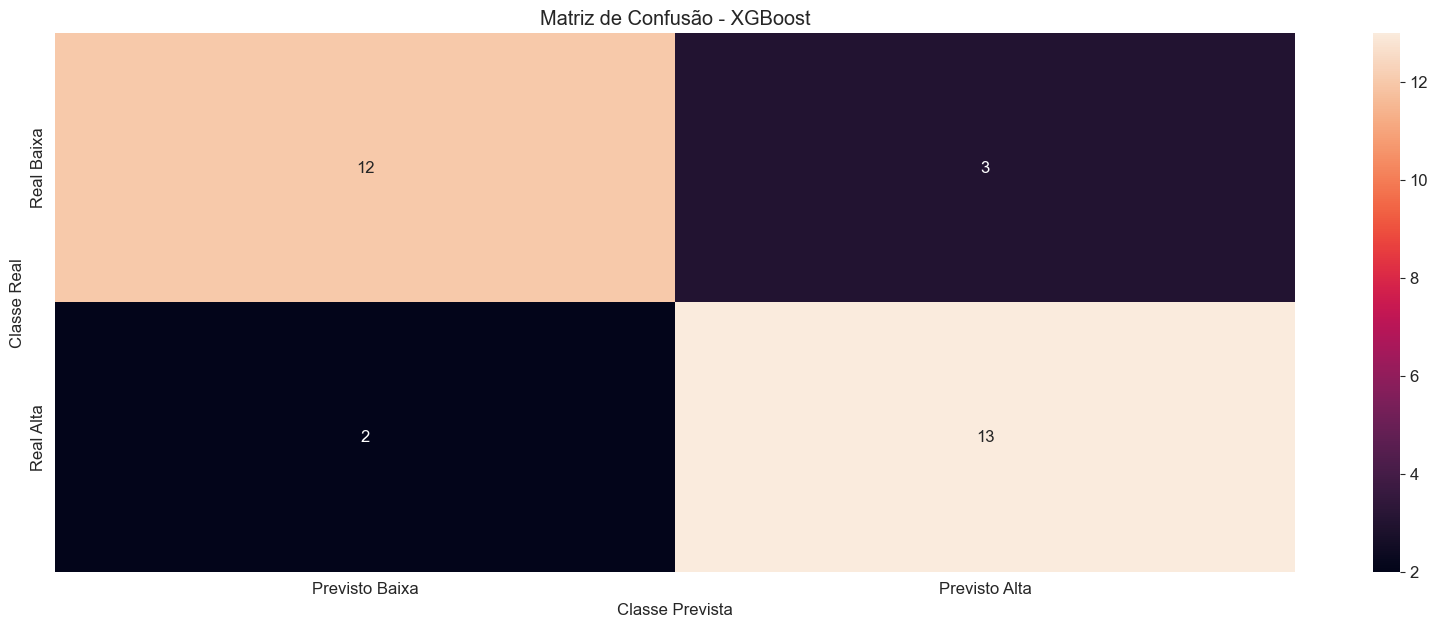

In [142]:
# matriz de confusão para o melhor modelo
best_model_name = performance.idxmax().iloc[0]
best_model = models[best_model_name]
cm = confusion_matrix(y_test, best_model.predict(X_test))

sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=['Previsto Baixa', 'Previsto Alta'], 
            yticklabels=['Real Baixa', 'Real Alta'])
plt.title(f'Matriz de Confusão - {best_model_name}')
plt.ylabel('Classe Real')
plt.xlabel('Classe Prevista')
plt.show()

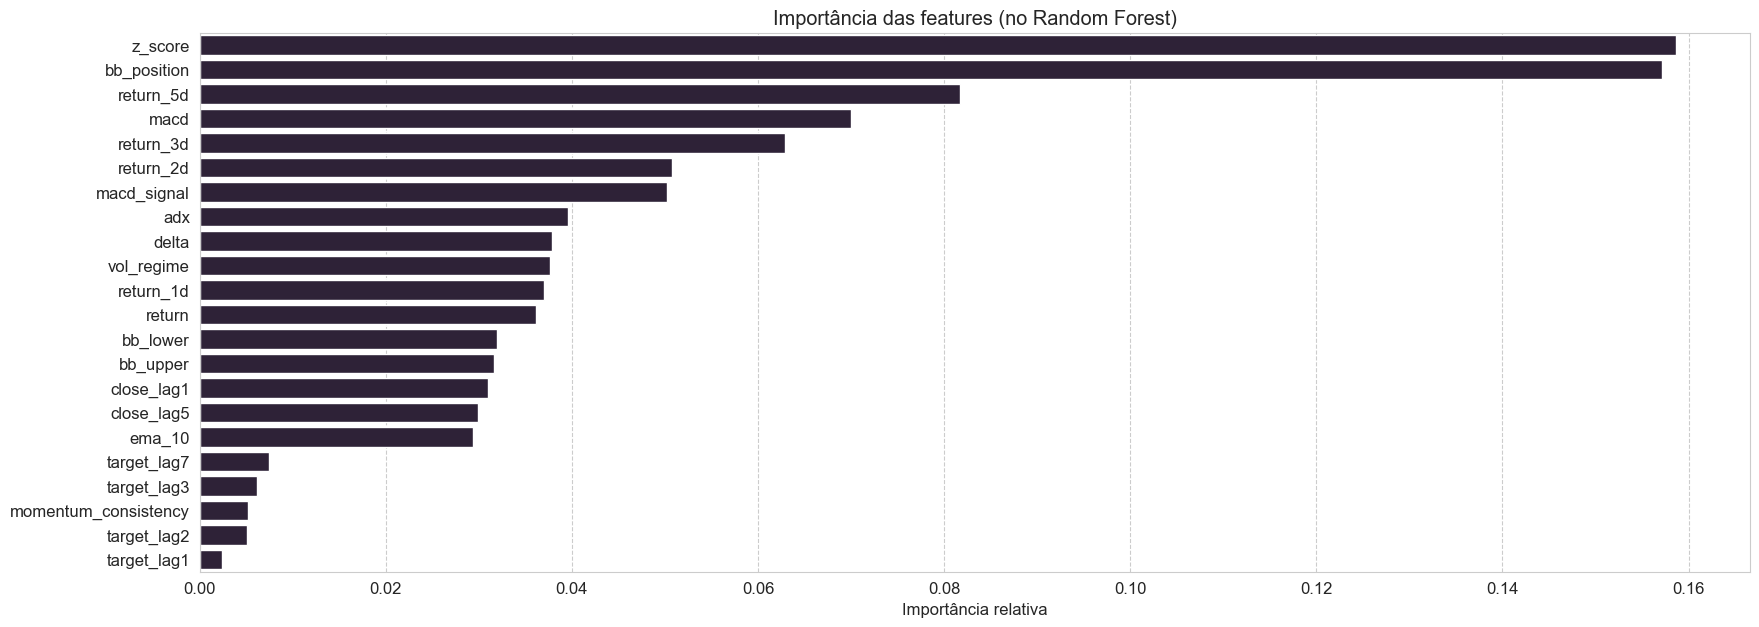

In [143]:
feature_importances = pd.Series(models['Random Forest'].feature_importances_, index=X_train.columns).sort_values(ascending=False).reset_index(name='importancia')

# plotando as features em ordem de importância para a previsão do modelo
sns.barplot(data=feature_importances, x='importancia', y='index')
plt.title('Importância das features (no Random Forest)')
plt.ylabel('')
plt.xlabel('Importância relativa')
plt.show()

In [144]:
# filtrar as features que atendem ao critério 95% 
feature_importances['acum'] = feature_importances['importancia'].cumsum()
best_features = feature_importances[feature_importances['acum'] < 0.96]['index'].sort_values().to_list()

print(f"Número de features original: {len(feature_importances)}")
print(f"Número de features após seleção com limiar de 95%: {len(best_features)}")
print("\nFeatures que serão mantidas para a otimização:")
print(list(best_features))

Número de features original: 22
Número de features após seleção com limiar de 95%: 16

Features que serão mantidas para a otimização:
['adx', 'bb_lower', 'bb_position', 'bb_upper', 'close_lag1', 'close_lag5', 'delta', 'macd', 'macd_signal', 'return', 'return_1d', 'return_2d', 'return_3d', 'return_5d', 'vol_regime', 'z_score']


## Ajuste de hiperparâmetros com validação cruzada

A validação cruzada ajuda a garantir que o modelo não está sobreajustado aos dados de treinamento e terá um bom desempenho em dados novos. 

In [145]:
# hiperparâmetros que iremos testar
# usamos 'model__parametro' por causa do pipeline
param_grid_svm = {
    'model__C': [0.1, 1, 10, 100],
    'model__gamma': ['scale', 'auto', 0.1, 1],
    'model__kernel': ['rbf']
}

# validação cruzada para dados de séries temporais
tscv = TimeSeriesSplit(n_splits=5)

# configuração do GridSearchCV
grid_search_svm = GridSearchCV(
    estimator=models['SVM'],
    param_grid=param_grid_svm,
    scoring='accuracy',
    cv=tscv,
    n_jobs=-1
)

grid_search_svm.fit(X_train, y_train)

# análise dos resultados
print("Melhores parâmetros para o SVM: ", grid_search_svm.best_params_)
print("Melhor acurácia na validação cruzada do SVM: {:.2%}".format(grid_search_svm.best_score_))

Melhores parâmetros para o SVM:  {'model__C': 100, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Melhor acurácia na validação cruzada do SVM: 74.84%


In [146]:
# melhor SVM no conjunto de teste
best_svm = grid_search_svm.best_estimator_
pred_test_svm = best_svm.predict(X_test)

print("Relatório de classificação do SVM:\n")
print(classification_report(y_test, pred_test_svm))

Relatório de classificação do SVM:

              precision    recall  f1-score   support

         0.0       0.85      0.73      0.79        15
         1.0       0.76      0.87      0.81        15

    accuracy                           0.80        30
   macro avg       0.81      0.80      0.80        30
weighted avg       0.81      0.80      0.80        30



In [147]:
# hiperparâmetros que iremos testar
param_grid_rf = {
    'n_estimators': [100, 200],          # Número de árvores
    'max_depth': [10, 20, None],         # Profundidade máxima de cada árvore
    'min_samples_leaf': [1, 5, 10],      # Número mínimo de amostras em uma folha
    'class_weight': ['balanced', None],  # Tratamento de desbalanceamento
    'max_features': ['sqrt', 'log2']     # Número de features a considerar em cada split
}

# validação cruzada para dados de séries temporais
tscv = TimeSeriesSplit(n_splits=5)

# configuração do GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=models['Random Forest'],
    param_grid=param_grid_rf,
    scoring='accuracy',
    cv=tscv,
    n_jobs=-1
)

grid_search_rf.fit(X_train, y_train)

# análise dos resultados
print("Melhores parâmetros para o Random Forest: ", grid_search_rf.best_params_)
print("Melhor acurácia na validação cruzada do Random Forest: {:.2%}".format(grid_search_rf.best_score_))

Melhores parâmetros para o Random Forest:  {'class_weight': None, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 200}
Melhor acurácia na validação cruzada do Random Forest: 75.01%


In [148]:
# melhor Random Forest no conjunto de teste
best_rf = grid_search_rf.best_estimator_
pred_test_rf = best_rf.predict(X_test)

print("Relatório de classificação do Random Forest:\n")
print(classification_report(y_test, pred_test_rf))

Relatório de classificação do Random Forest:

              precision    recall  f1-score   support

         0.0       0.68      0.87      0.76        15
         1.0       0.82      0.60      0.69        15

    accuracy                           0.73        30
   macro avg       0.75      0.73      0.73        30
weighted avg       0.75      0.73      0.73        30



In [59]:
# hiperparâmetros que iremos testar
param_grid_lp = {
    'model__penalty': ['elasticnet'],              # apenas elasticnet, pois exige compatibilidade
    'model__solver': ['saga'],                     # único solver que suporta elasticnet
    'model__l1_ratio': [0.5],                      # valor fixo equilibrado entre L1 e L2
    'model__C': [1.0],                             # regularização moderada
    'model__class_weight': ['balanced'],           # útil para dados desbalanceados
    'model__max_iter': [500]                       # iterações suficientes para convergência
}

# validação cruzada para dados de séries temporais
tscv = TimeSeriesSplit(n_splits=5)

# configuração do GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=models['Logistic Regression'],
    param_grid=param_grid_lp,
    scoring='accuracy',
    cv=tscv,
    n_jobs=-1
)

grid_search_rf.fit(X_train, y_train)

# análise dos resultados
print("Melhores parâmetros para o Random Forest: ", grid_search_rf.best_params_)
print("Melhor acurácia na validação cruzada do Random Forest: {:.2%}".format(grid_search_rf.best_score_))

Melhores parâmetros para o Random Forest:  {'model__C': 1.0, 'model__class_weight': 'balanced', 'model__l1_ratio': 0.5, 'model__max_iter': 500, 'model__penalty': 'elasticnet', 'model__solver': 'saga'}
Melhor acurácia na validação cruzada do Random Forest: 63.35%


c:\Users\jacom\anaconda3\envs\ibov_p_11\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
